In [2]:
from astroquery.gaia import Gaia
from scipy import stats

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import os

In [3]:
cols =  ['source_id', 'random_index', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 
         'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 
         'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
         'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error',
         'phot_g_mean_mag', 'phot_bp_n_obs', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
         'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag', 'phot_rp_n_obs', 'phot_rp_mean_flux',
         'phot_rp_mean_flux_error', 'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag',
         'phot_bp_rp_excess_factor', 'phot_bp_n_contaminated_transits', 'phot_bp_n_blended_transits',
         'phot_rp_n_blended_transits',
         'bp_rp', 'bp_g', 'g_rp', 'radial_velocity', 'radial_velocity_error',
         'rv_expected_sig_to_noise', 'rv_renormalised_gof', 'rv_chisq_pvalue', 
         'rv_template_teff', 'rv_template_logg', 'rv_template_fe_h', 'rv_atm_param_origin',
         'vbroad', 'vbroad_error', 'vbroad_nb_transits',
         'grvs_mag', 'grvs_mag_error', 'grvs_mag_nb_transits',
         'rvs_spec_sig_to_noise', 'phot_variable_flag',
         'l', 'b', 'ecl_lon', 'ecl_lat',
         'in_qso_candidates', 'in_galaxy_candidates', 'non_single_star', 'has_xp_continuous', 'has_xp_sampled', 'has_rvs', 'has_epoch_photometry', 'has_epoch_rv', 
         'has_mcmc_gspphot', 'has_mcmc_msc', 
         'teff_gspphot', 'teff_gspphot_lower', 'teff_gspphot_upper', 'logg_gspphot',
         'logg_gspphot_lower', 'logg_gspphot_upper',
         'mh_gspphot', 'mh_gspphot_lower', 'mh_gspphot_upper',
         'distance_gspphot', 'distance_gspphot_lower', 'distance_gspphot_upper',
         'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 'ag_gspphot_lower', 'ag_gspphot_upper', 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 
         'ebpminrp_gspphot_upper', 'parallax_corr', 'parallax_corr_error', 'distance', 'x', 'y', 'z', 'pml', 'pmb', 'vx', 'vy', 'vz', 'X', 'Y', 'Z', 'vX', 'vY', 'vZ', 'phi', 
         'R', 'vR', 'vT', 'v_toomre']
print(len(cols))
custom_cols = ['source_id', 'random_index', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 
         'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 
         'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
         'radial_velocity', 'radial_velocity_error',
         'rv_expected_sig_to_noise', 'rv_renormalised_gof', 'rv_chisq_pvalue', 
         'rv_template_teff', 'rv_template_logg', 'rv_template_fe_h', 'rv_atm_param_origin',
         'l', 'b', 'ecl_lon', 'ecl_lat',
         'ebpminrp_gspphot_upper', 'parallax_corr', 'parallax_corr_error', 'distance', 'x', 'y', 'z', 'pml', 'pmb', 'vx', 'vy', 'vz', 'X', 'Y', 'Z', 'vX', 'vY', 'vZ', 'phi', 
         'R', 'vR', 'vT', 'v_toomre']
print(len(custom_cols))

120
60


In [4]:
premade_testing_data = "c:\\Games\\ThesisData\\precutGaiaData\\GaiaDR3_poege5_DoddQuality_2p5kpc.parquet"
df_test = pl.read_parquet(premade_testing_data).select(custom_cols)

In [5]:
v_lsr = 232.8 # McMillan 2017

df_test = df_test.with_columns(
    (pl.col('vT')-v_lsr).alias('vT_adj'))
#print(df_test.filter(pl.col('vT_adj')))
filtered_vT = df_test.filter(pl.col('vT_adj').is_between(-250, 150)).select('vT_adj').to_numpy()
# min_val = abs(filtered_vT.min())+1e-6
# max_val = abs(filtered_vT.max())+1e-6

In [14]:
N_bins = 350

counts, bin_edges  = np.histogram(filtered_vT, bins=N_bins, density=True)
bins = (bin_edges[:-1] + bin_edges[1:]) / 2

In [37]:
skew_params = stats.skewnorm.fit(filtered_vT)
johnsonsu_params = stats.johnsonsu.fit(filtered_vT)
gennorm_params = stats.gennorm.fit(filtered_vT)
norm_params = stats.norm.fit(filtered_vT)

skew_params, johnsonsu_params, gennorm_params, norm_params

((np.float64(-2.6379929163289866),
  np.float64(19.596113686591757),
  np.float64(43.79896415536412)),
 (np.float64(1.0579189664597481),
  np.float64(1.8589614313524991),
  np.float64(15.032248034994801),
  np.float64(39.512240823422516)),
 (np.float64(1.217875152812287),
  np.float64(-9.61702122637741),
  np.float64(27.645909633091172)),
 (np.float64(-12.433031157269982), np.float64(29.874441995247405)))

In [ ]:
# skew_params = np.array([np.float64(-2.944170361698869), 
#                         np.float64(33.928170982822174), 
#                         np.float64(46.41049302991353)])

# johnsonsu_params = np.array([np.float64(0.9773762000866706), 
#                              np.float64(1.7093302703822348), 
#                              np.float64(25.979702510731315), 
#                              np.float64(36.1019113951688)])

# gennorm_params = np.array([np.float64(1.1142722682176385), 
#                            np.float64(3.440172312917782), 
#                            np.float64(25.489601245871576)])

# norm_params = np.array([np.float64(-0.014203396408552314), 
#                         np.float64(31.652001923414876)])

stats.skew(filtered_vT), stats.kurtosis(filtered_vT)

(array([-2.15881887]), array([13.94752734]))

In [15]:
from scipy.optimize import curve_fit

def skewnorm_func(x, a, loc, scale):
    return stats.skewnorm.pdf(x, a, loc, scale)

def norm_func(x, loc, scale):
    return stats.norm.pdf(x, loc, scale)

def gennorm_func(x, beta, loc, scale):
    return stats.gennorm.pdf(x, beta, loc, scale)

def johnsonsu_func(x, a, b, loc, scale):
    return stats.johnsonsu.pdf(x, a, b, loc, scale)

skew_popt, skew_pcov = curve_fit(skewnorm_func, bins, counts)
norm_popt, norm_pcov = curve_fit(norm_func, bins, counts)
gennorm_popt, gennorm_pcov = curve_fit(gennorm_func, bins, counts)
johnsonsu_popt, johnsonsu_pcov = curve_fit(johnsonsu_func, bins, counts)

skew_popt, norm_popt, gennorm_popt, johnsonsu_popt

(array([-2.04863206, 15.43199772, 36.70874027]),
 array([-7.42644748, 24.62611634]),
 array([ 1.66414271, -7.22760763, 33.0899005 ]),
 array([ 1.00290094,  2.03880393, 14.28369099, 44.95708965]))

In [17]:
# fit_results = np.array([
#     ["skewnorm_func", skew_params],
#     ["norm_func", norm_params],
#     ["gennorm_func", gennorm_params],
#     ["johnsonsu_func", johnsonsu_params]
# ], dtype=object)

lsq_results = np.array([
    ["skewnorm_func", skew_popt],
    ["norm_func", norm_popt],
    ["gennorm_func", gennorm_popt],
    ["johnsonsu_func", johnsonsu_popt]
], dtype=object)

def function_comparer(x, y, results):
    def r_squared(ydata, xdata, params, f):
        residuals = ydata- f(xdata, *params)
        ss_res = np.sum(residuals**2)

        ss_tot = np.sum((ydata-np.mean(ydata))**2)

        r_squared = 1 - (ss_res / ss_tot)
        return r_squared

    def residuals(ydata, xdata, params, f):
        return np.sum((ydata - f(xdata, *params))**2)

    def AIC(xdata, params, f):
        k = len(params)
        logLik = np.sum(f(xdata, *params))
        return 2*k - 2*logLik

    compare_vals = np.zeros((len(results), 3))

    for i, single_result in enumerate(results):
        func = getattr(stats, single_result[0][:-5])

        compare_vals[i, 0] = r_squared(y, x, single_result[1], func.pdf)
        compare_vals[i, 1] = residuals(y, x, single_result[1], func.pdf)
        compare_vals[i, 2] =  AIC(x, single_result[1], func.logpdf)
    
    results = results[np.argsort(compare_vals[:, 2])]
    compare_vals = compare_vals[np.argsort(compare_vals[:, 2])]
    
    for i, [r2, res, AIC_val] in enumerate(compare_vals):
        print(f"{results[i][0]}: r2 = {r2:.4f}, S = {res:.6f}, AIC = {AIC_val:.3f}")
# print(f'MLE results:')
# function_comparer(bins, counts, fit_results)
print(f'Least Squares results:')
function_comparer(bins, counts, lsq_results)

Least Squares results:
johnsonsu_func: r2 = 0.9996, S = 0.000003, AIC = 6481.294
gennorm_func: r2 = 0.9914, S = 0.000064, AIC = 8638.488
skewnorm_func: r2 = 0.9978, S = 0.000016, AIC = 9996.753
norm_func: r2 = 0.9888, S = 0.000083, AIC = 11630.464


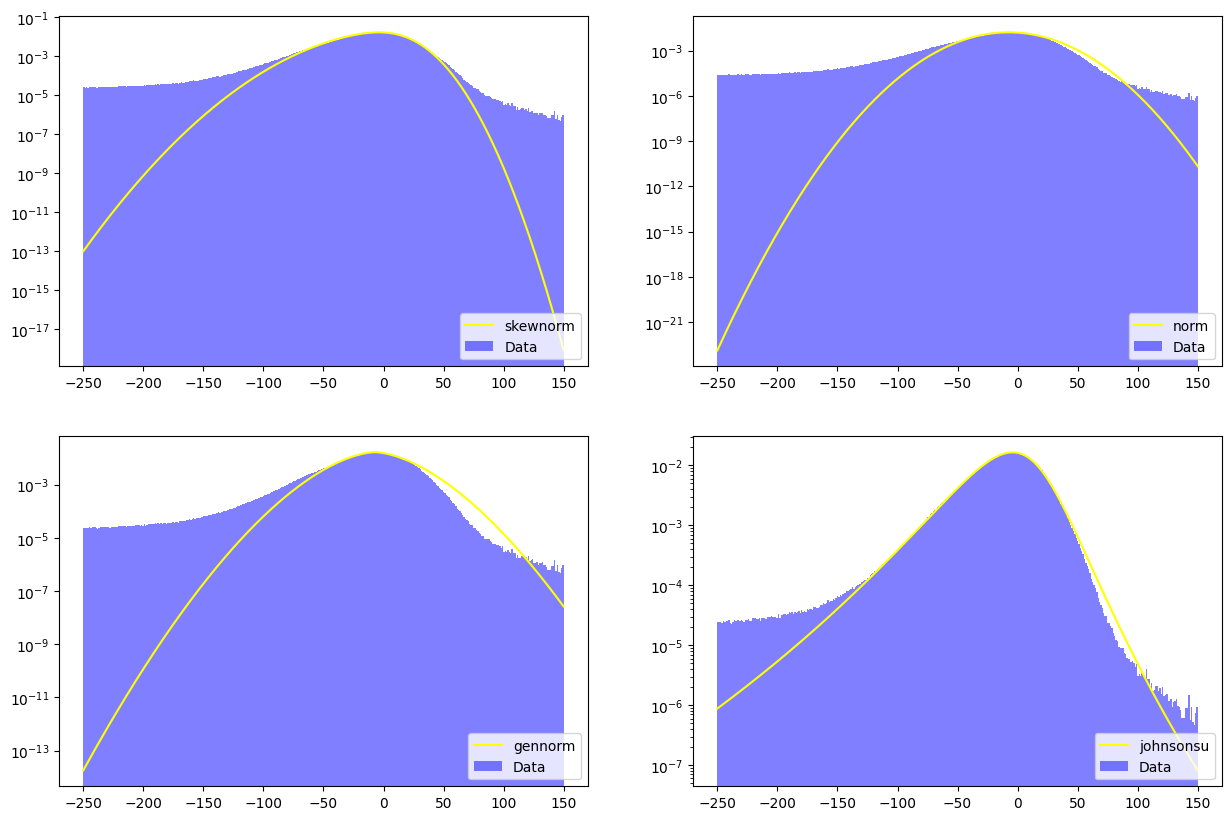

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

sample_vT = np.linspace(filtered_vT.min(), filtered_vT.max(), 1000)

for i, ax in enumerate(axs):
    func_name = lsq_results[i][0][:-5]
    func = getattr(stats, func_name)
    ax.plot(sample_vT, func.pdf(sample_vT, *lsq_results[i][1]), label=func_name, color='yellow')
    # ax.plot(sample_vT, func.pdf(sample_vT, *fit_results[i][1]), label='MLE '+func_name, color='magenta', lw=3, alpha=0.7)
    ax.hist(filtered_vT, bins=N_bins, density=True, alpha=0.5, label='Data', color='blue')
    ax.legend(loc='lower right')
    ax.set_yscale('log')
plt.show()

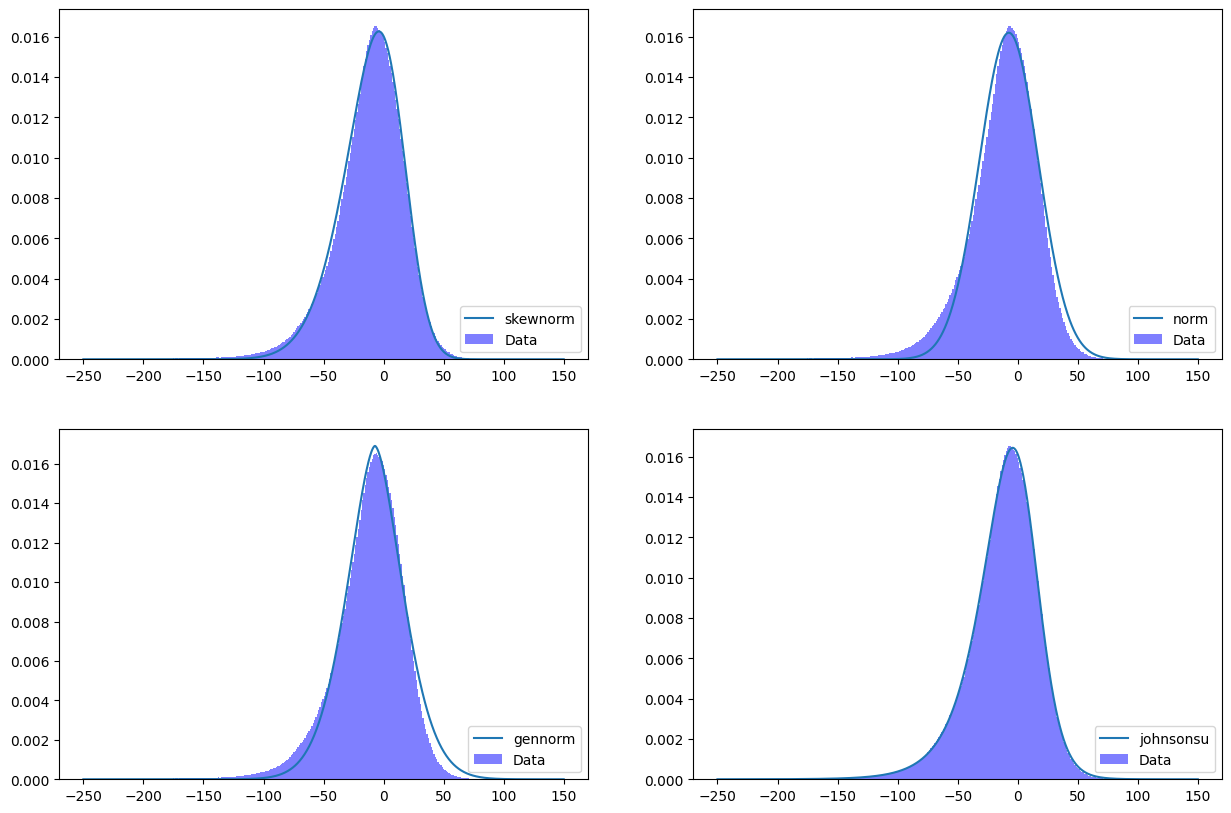

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    func_name = lsq_results[i][0][:-5]
    func = getattr(stats, func_name)
    ax.plot(sample_vT, func.pdf(sample_vT, *lsq_results[i][1]), label=func_name)
    # ax.plot(sample_vT, func.pdf(sample_vT, *fit_results[i][1]), label='MLE '+func_name, color='magenta', lw=1)
    ax.hist(filtered_vT, bins=N_bins, density=True, alpha=0.5, label='Data', color='blue')
    ax.legend(loc='lower right')
    # ax.set_yscale('log')
plt.show()

Create class that handles pipeline of finding best fit parameters (MLE or LSQ), plots results and returns statistics.

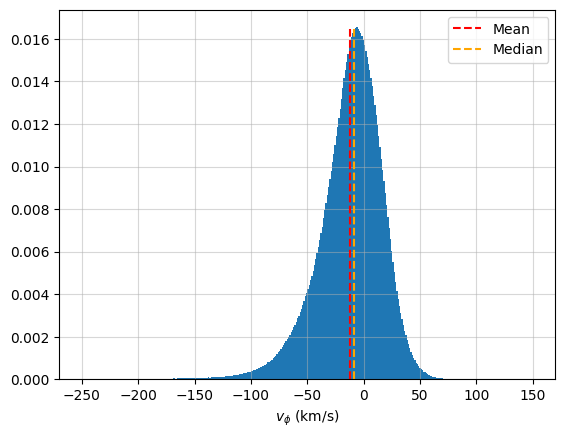

In [62]:
import customClasses as vF
import importlib
importlib.reload(vF)
import pickle

with open('savedMLEparams.pickle', 'rb') as handle:
    savedMLEparams = pickle.load(handle)

with open('savedLSQparams.pickle', 'rb') as handle:
    savedLSQparams = pickle.load(handle)
N_bins = 350
exclude = [2]
func_names = ['skewnorm', 'norm', 'gennorm', 'johnsonsu']
param_numbers = [3, 2, 3, 4]

for item in exclude:
    func_names.pop(item)
    param_numbers.pop(item)
    savedMLEparams.pop(item)
    savedLSQparams.pop(item)

testFitter = vF.velocityFitter(filtered_vT, N_bins, func_names, param_numbers, MLEparams=savedMLEparams, LSQparams=savedLSQparams)
testFitter.init_plot()
# testFitter.MLE_fit()
# testFitter.LSQ_fit()

In [63]:
testFitter.function_comparer(method='MLE')
testFitter.function_comparer(method='LSQ')

MLE results:
johnsonsu: r2 = 0.9991, S = 0.000007, AIC = 6339.983
norm: r2 = 0.9432, S = 0.000422, AIC = 8806.973
skewnorm: r2 = 0.9858, S = 0.000106, AIC = 8985.419
LSQ results:
johnsonsu: r2 = 0.9996, S = 0.000003, AIC = 6481.294
skewnorm: r2 = 0.9978, S = 0.000016, AIC = 9996.753
norm: r2 = 0.9888, S = 0.000083, AIC = 11630.464


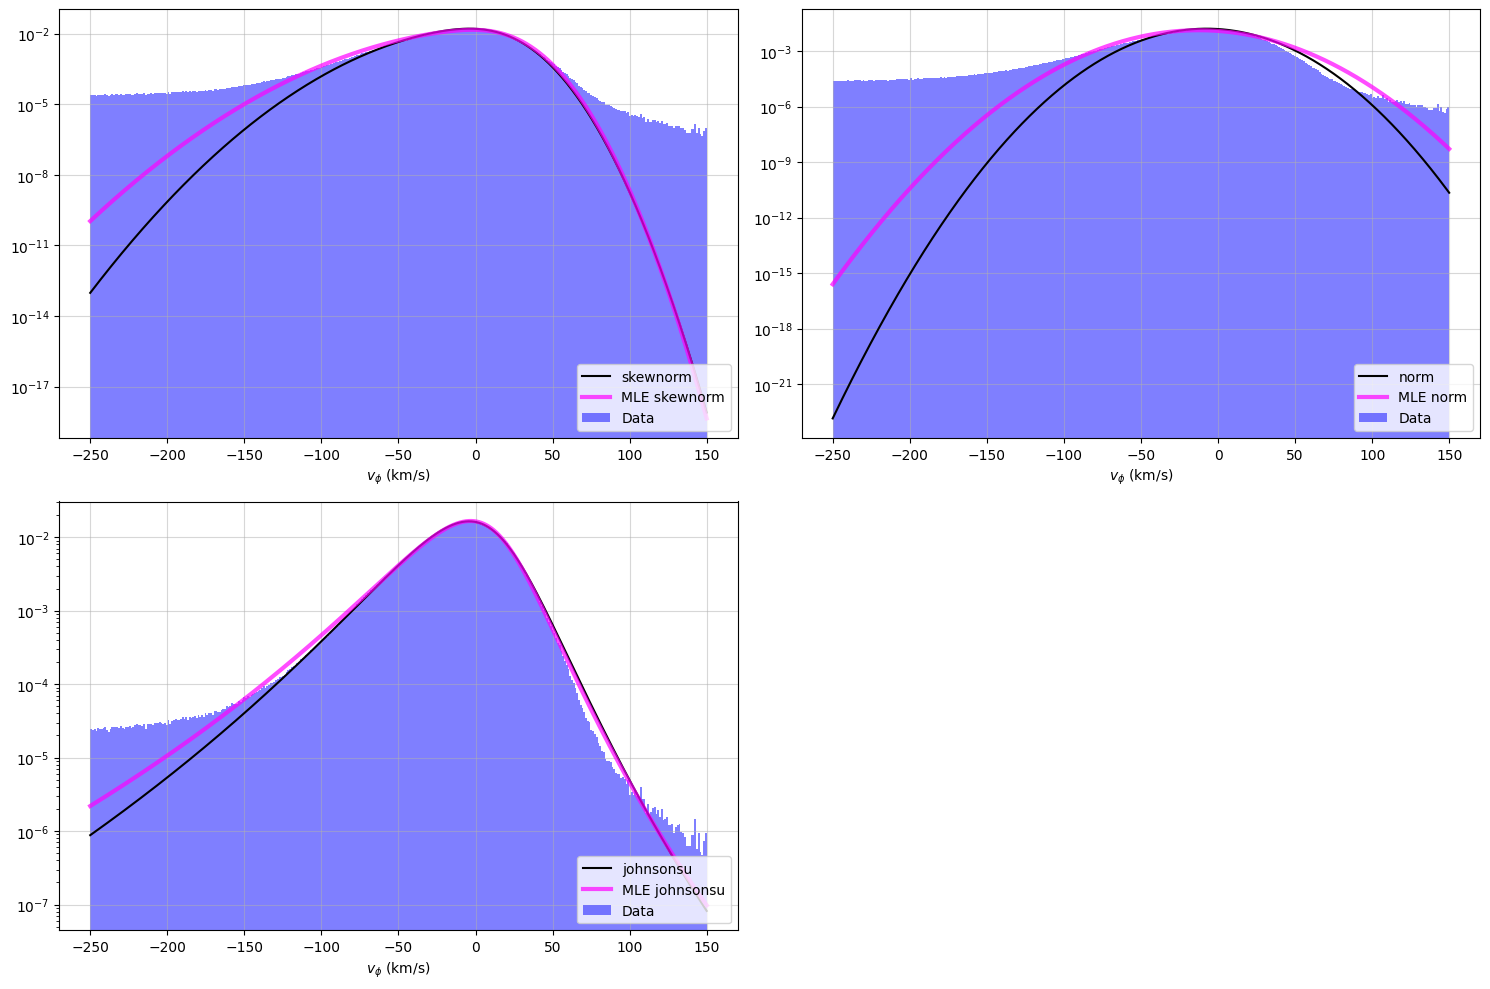

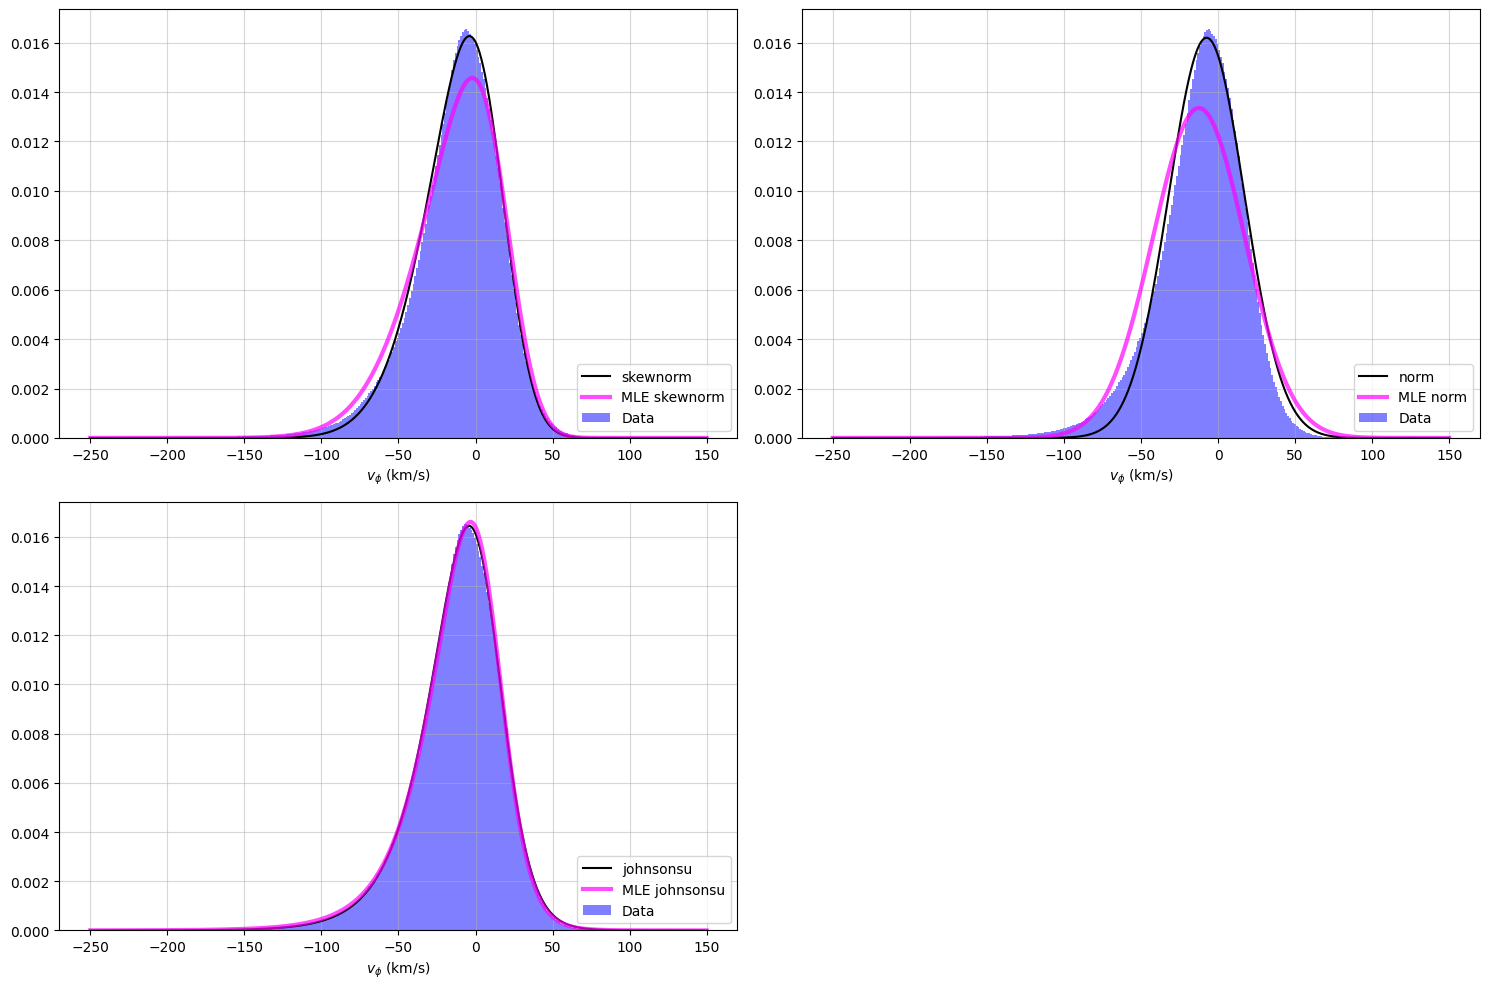

In [64]:
testFitter.plot_distributions(log=True)
testFitter.plot_distributions(log=False)